# Env Prep

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Wed Aug 20 16:34:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     Off |   00000000:00:07.0 Off |                  N/A |
| 30%   32C    P0             N/A /  350W |       1MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Config

In [ ]:
import os
import shutil
import subprocess
import sys
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, List, Literal, Union

EnvModeType = Literal["colab", "remote", "local"]


@dataclass(frozen=True)
class Config:
    env_mode: EnvModeType
    selected_subsets: List[str] = field(
        default_factory=lambda: ["SUDOKU_4", "SUDOKU_5", "SUDOKU_6"]
    )

    # Derived fields (init=False)
    data_root: Path = field(init=False)
    base_dir: Path = field(init=False)
    taco_raw_dir: Path = field(init=False)
    taco_file_paths: List[Path] = field(init=False)
    normalized_sets_dir: Path = field(init=False)
    finetune_dir: Path = field(init=False)
    train_dir: Path = field(init=False)
    val_dir: Path = field(init=False)
    test_dir: Path = field(init=False)

    def __post_init__(self) -> None:
        # Set data_root based on env_mode (defaults; override in factory if needed)
        data_root_map = {
            # "local": Path.home() / "mnt/shared",
            "local": Path("/mnt/shared"),
            # "remote": Path("/mnt/data"),
            "remote": Path.home(),
            "colab": Path("/content/drive/MyDrive"),
        }
        object.__setattr__(
            self, "data_root", data_root_map.get(self.env_mode, Path.cwd())
        )

        # Derive other paths
        object.__setattr__(
            self, "base_dir", self.data_root / "datasets/sen2venus"
        )
        # object.__setattr__(self, "taco_raw_dir", self.base_dir / "TACO_raw_data")
        # object.__setattr__(
        #     self,
        #     "taco_file_paths",
        #     [self.taco_raw_dir / f"{subset}.taco" for subset in self.selected_subsets],
        # )
        object.__setattr__(
            self, "normalized_sets_dir", self.base_dir / "normalized_sets"
        )
        object.__setattr__(self, "finetune_dir", self.base_dir / "finetune")
        object.__setattr__(self, "train_dir", self.normalized_sets_dir / "train")
        object.__setattr__(self, "val_dir", self.normalized_sets_dir / "val")
        object.__setattr__(self, "test_dir", self.normalized_sets_dir / "test")

    def validate(self) -> None:
        """Validate config paths exist; raise errors otherwise."""
        missing_paths = []
        for attr in [
            "data_root",
            "base_dir",
            # "taco_raw_dir",
            "normalized_sets_dir",
            "finetune_dir",
            "train_dir",
            "val_dir",
            "test_dir",
        ]:
            path: Path = getattr(self, attr)
            if not path.exists():
                missing_paths.append(str(path))
        if missing_paths:
            raise ValueError(f"Missing paths: {', '.join(missing_paths)}")
        # for file_path in self.taco_file_paths:
        #     if not file_path.exists():
        #         missing_paths.append(str(file_path))
        if missing_paths:
            raise ValueError(f"Missing taco files: {', '.join(missing_paths)}")


def setup_environment(env_mode: EnvModeType) -> None:
    """Perform environment-specific setup (side effects isolated here)."""
    if env_mode == "colab":
        try:
            import super_image
        except ImportError:
            print("Installing 'super-image'...")
            try:
                subprocess.run(["pip", "install", "--quiet", "super-image"], check=True)
            except subprocess.CalledProcessError as e:
                raise RuntimeError(f"Failed to install super-image: {e}")

        try:
            from google.colab import drive

            drive.mount("/content/drive", force_remount=True)
        except ImportError:
            raise RuntimeError("Google Colab module not found. Are you in Colab?")
        except Exception as e:
            raise RuntimeError(f"Failed to mount Google Drive: {e}")

        # Optional: Copy data to local /content for faster I/O in Colab
        colab_vm_dir = Path("/content/taco_normalized")
        if not colab_vm_dir.exists():
            print("Copying normalized data to local Colab storage for performance...")
            shutil.copytree(
                Path(
                    "/content/drive/MyDrive/datasets/sen2venus/normalized_sets"
                ),
                colab_vm_dir,
            )
            print("Copy complete.")
        # Avoid os.chdir; let users handle working dir if needed

    elif env_mode == "remote":
        print("Remote environment detected. No specific setup needed.")

    elif env_mode == "local":
        print("Local environment detected. Ensuring dependencies...")


def create_config(env_mode: EnvModeType | None = None) -> Config:
    """Factory to create and setup config based on detected environment."""
    if env_mode is None:
        if "google.colab" in sys.modules:
            env_mode = "colab"
        elif "REMOTE_ENV_VAR" in os.environ:
            env_mode = "remote"
        else:
            env_mode = "local"

    setup_environment(env_mode)
    config = Config(env_mode=env_mode)
    config.validate()
    return config


In [ ]:
config = create_config('remote')
print(config.data_root)

Remote environment detected. No specific setup needed.
/home/ubuntu


## Project imports

In [ ]:
from collections import OrderedDict

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from super_image import (
    EdsrConfig,
    EdsrModel,
    PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from super_image.data import EvalMetrics
from super_image.trainer import logger
from super_image.trainer_utils import EvalPrediction
from super_image.utils.metrics import AverageMeter, compute_metrics
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Data Loader

In [ ]:
class PreNormalizedDataset(Dataset):
    """
    Efficiently reads pre-processed, sharded tensor files from disk.
    """
    def __init__(self, shard_dir: Union[str, Path]):
        self.shard_dir = Path(shard_dir)
        self.shard_paths: List[Path] = sorted(self.shard_dir.glob("*.pt"))

        if not self.shard_paths:
            raise ValueError(f"No shard files ('*.pt') found in {self.shard_dir}")

        # To calculate length, we check the size of the first shard and assume
        # all but the last are the same size.
        first_shard = torch.load(self.shard_paths[0])
        self.shard_size = len(first_shard)
        last_shard = torch.load(self.shard_paths[-1])
        self.length = (len(self.shard_paths) - 1) * self.shard_size + len(last_shard)

        # Simple cache to avoid re-loading the same shard consecutively
        self._cache = {}
        self._cached_shard_index = -1
        print(f"Initialized dataset from {self.shard_dir} with {self.length} samples across {len(self.shard_paths)} shards.")


    def __len__(self):
        return self.length

    def __getitem__(self, idx)->Dict[str, np.ndarray]:
        shard_index = idx // self.shard_size
        index_in_shard = idx % self.shard_size

        if shard_index != self._cached_shard_index:
            self._cache = torch.load(self.shard_paths[shard_index])
            self._cached_shard_index = shard_index

        # coupled with TACORGBDataset dataset class
        # each item in the shard is a squeezed dictionary with keys lr and hr
        squeezed_sample = self._cache[index_in_shard]
        return squeezed_sample['lr'], squeezed_sample['hr']


In [ ]:
try:
    test_data_dir = Path("/content/taco_normalized/test") if config.env_mode == "colab" else config.test_dir

    test_dataset = PreNormalizedDataset(test_data_dir)
    # For evaluation, batch size is typically 1 to measure per-image metrics.
    test_dataloader = DataLoader(test_dataset, batch_size=1)
    print(f"Loaded test dataset with {len(test_dataset)} samples.")
except Exception as e:
    print(f"❌ ERROR: Failed to load the test dataset from '{test_data_dir}': {e}")

Initialized dataset from /home/ubuntu/datasets/sen2venus/normalized_sets/test with 556 samples across 1 shards.
Loaded test dataset with 556 samples.


# Load the Models

In [ ]:
def load_model(finetune_dir: Path|str, pre_trained : bool, scale: int = 2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_data_dir = config.test_dir
    checkpoint_path = finetune_dir / 'best_model_checkpoint.pt'

    if pre_trained:
        model = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=2)
    else:
        config_edsr_8block = EdsrConfig(
            scale=2,
            n_resblocks=8,
        )
        model = EdsrModel(config_edsr_8block)

    # If multiple GPUs are available, wrap the model in DataParallel
    # This ensures the model's structure matches the training environment.
    if torch.cuda.device_count() > 1:
      print(f"Using {torch.cuda.device_count()} GPUs. Wrapping model in DataParallel.")
      model = torch.nn.DataParallel(model)

    model.to(device)

    # load the state dictionary from best checkpoint
    print(f"Loading best model checkpoint from: {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model_state_dict = checkpoint['model_state_dict']

        # --- Logic to handle all DataParallel cases ---
        is_model_parallel = isinstance(model, torch.nn.DataParallel)
        is_checkpoint_parallel = list(model_state_dict.keys())[0].startswith('module.')

        final_state_dict = OrderedDict()

        if is_model_parallel and not is_checkpoint_parallel:
            # If the current model is parallel but the checkpoint isn't, add "module." prefix
            print("Model is parallel, checkpoint is not. Adding 'module.' prefix to keys...")
            for k, v in model_state_dict.items():
                final_state_dict['module.' + k] = v
        elif not is_model_parallel and is_checkpoint_parallel:
            # If the checkpoint is parallel but the current model isn't, strip "module." prefix
            print("Checkpoint is parallel, model is not. Stripping 'module.' prefix from keys...")
            for k, v in model_state_dict.items():
                final_state_dict[k[7:]] = v # k[7:] removes 'module.'
        else:
            # If they are both parallel or both not parallel, the keys match already.
            print("Model and checkpoint states match. Loading directly.")
            final_state_dict = model_state_dict

        # Load the correctly formatted state dictionary
        model.load_state_dict(final_state_dict)

        print(f"\n✅Successfully loaded model from epoch {checkpoint['epoch']} with best validation PSNR {checkpoint['best_metric']:.4f}")

    except FileNotFoundError:
        print(f"❌ ERROR: Checkpoint file not found at '{checkpoint_path}'. Please verify the path.")
    except Exception as e:
        print(f"❌ ERROR: An error occurred while loading the checkpoint: {e}")

    model.eval()

    return model, device

In [ ]:
model_16_block, device_16_block = load_model(config.finetune_dir / 'edsr_base', pre_trained=True)

https://huggingface.co/eugenesiow/edsr-base/resolve/main/pytorch_model_2x.pt
Loading best model checkpoint from: /home/ubuntu/datasets/sen2venus/finetune/edsr_base/best_model_checkpoint.pt
Model and checkpoint states match. Loading directly.

✅Successfully loaded model from epoch 14 with best validation PSNR 47.3143


In [ ]:
model_8_block, device_8_block = load_model(config.finetune_dir / 'edsr_base_8_block', pre_trained=False)

Loading best model checkpoint from: /home/ubuntu/datasets/sen2venus/finetune/edsr_base_8_block/best_model_checkpoint.pt
Model and checkpoint states match. Loading directly.

✅Successfully loaded model from epoch 14 with best validation PSNR 46.5171


# Step 1: Quantitative Evaluation on the Test Set

### Trained 8 block

In [ ]:
EvalMetrics().evaluate(model_16_block, test_dataset)
print(f"Total images evaluated: {len(test_dataset)}")

Evaluating dataset:   0%|          | 0/556 [00:00<?, ?it/s]

scale:2      eval psnr: 47.46     ssim: 0.9910
Total images evaluated: 556


In [ ]:
EvalMetrics().evaluate(model_8_block, test_dataset)
print(f"Total images evaluated: {len(test_dataset)}")

Evaluating dataset:   0%|          | 0/556 [00:00<?, ?it/s]

scale:2      eval psnr: 46.67     ssim: 0.9893
Total images evaluated: 556


# Step 2: Qualitative Visual Analysis

## convert tensors to displayable images

In [ ]:
def tensor_to_image_enhanced(tensor):
    """
    Converts a PyTorch tensor to a NumPy image for plotting, with
    contrast stretching for improved visualization.
    """
    # Move tensor to CPU and convert to NumPy array
    image = tensor.cpu().numpy()

    # --- Start of Contrast Stretching ---
    # Calculate the 2nd and 98th percentiles for each channel
    # This determines the new "min" and "max" for our visual range
    vmin = np.percentile(image, 2, axis=(1, 2), keepdims=True)
    vmax = np.percentile(image, 98, axis=(1, 2), keepdims=True)

    # Clip the image to this new range, ignoring extreme outliers
    image = np.clip(image, vmin, vmax)

    # Rescale the image to the [0, 1] range for display
    # This is the core of the stretching
    image = (image - vmin) / (vmax - vmin)
    # --- End of Contrast Stretching ---

    # Tranpose from (C, H, W) to (H, W, C)
    image = np.transpose(image, (1, 2, 0))

    # Final clip to handle any potential floating point inaccuracies
    image = np.clip(image, 0, 1)

    return image


def generate_comparison_data(
    dataset, index, model_16_block, model_8_block, device_16_block, device_8_block
):
    """
    A self-contained function to generate all necessary images and metrics for comparison.

    Returns:
        A dictionary containing all NumPy images and their corresponding PSNR/SSIM scores.
    """

    # 1. Get base tensors from the dataset
    lr_tensor, hr_tensor = dataset[index]
    hr_batch_for_metrics = hr_tensor.unsqueeze(0).to(
        device_16_block
    )  # Use one device for metrics

    # 2. Get the model scale (assuming both models have the same scale)
    unwrapped_model_16 = (
        model_16_block.module
        if isinstance(model_16_block, torch.nn.DataParallel)
        else model_16_block
    )
    scale = unwrapped_model_16.config.scale

    # 3. Generate Super-Resolved (SR) images for both models
    with torch.no_grad():
        lr_batch_16 = lr_tensor.unsqueeze(0).to(device_16_block)
        sr_16_tensor = model_16_block(lr_batch_16).squeeze(0)

        lr_batch_8 = lr_tensor.unsqueeze(0).to(device_8_block)
        sr_8_tensor = model_8_block(lr_batch_8).squeeze(0)

    # 4. Generate the Bicubic Interpolation image
    hr_height, hr_width = hr_tensor.shape[1], hr_tensor.shape[2]
    bicubic_tensor = F.interpolate(
        lr_tensor.unsqueeze(0),
        size=(hr_height, hr_width),
        mode="bicubic",
        align_corners=False,
    ).squeeze(0)

    # 5. Calculate PSNR/SSIM metrics for each upscaled image
    tensors_to_metric = {
        "bicubic": bicubic_tensor,
        "sr_8": sr_8_tensor,
        "sr_16": sr_16_tensor,
    }

    metrics_dict = {}
    for name, pred_tensor in tensors_to_metric.items():
        pred_batch = pred_tensor.unsqueeze(0).to(device_16_block)
        metrics = compute_metrics(
            EvalPrediction(predictions=pred_batch, labels=hr_batch_for_metrics),
            scale=scale,
        )
        metrics_dict[name] = metrics

    # 6. Convert all tensors to displayable NumPy images
    images_dict = {
        "lr": tensor_to_image_enhanced(lr_tensor),
        "bicubic": tensor_to_image_enhanced(bicubic_tensor),
        "sr_8": tensor_to_image_enhanced(sr_8_tensor),
        "sr_16": tensor_to_image_enhanced(sr_16_tensor),
        "hr": tensor_to_image_enhanced(hr_tensor),
    }

    return {"images": images_dict, "metrics": metrics_dict}


def plot_final_comparison(comparison_data, zoom_rect):
    """
    Takes the data generated by generate_comparison_data and creates the final plot.
    """
    images = comparison_data["images"]
    metrics = comparison_data["metrics"]
    x, y, w, h = zoom_rect

    # 1. Plot the original Low-Resolution image separately for clarity
    fig_lr, ax_lr = plt.subplots(1, 1, figsize=(6, 6))
    ax_lr.imshow(images["lr"])
    ax_lr.set_title(
        f'Low-Resolution Input ({images["lr"].shape[1]}x{images["lr"].shape[0]})',
        fontsize=16,
    )
    ax_lr.add_patch(
        patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    )
    plt.show()

    # 2. Create the main 2x4 grid for comparison
    fig, axes = plt.subplots(2, 4, figsize=(28, 14))

    # --- Top Row: Full Upscaled Images ---
    # Define the images and their corresponding data keys
    plot_order = [
        ("Bicubic", "bicubic"),
        ("EDSR 8-Block", "sr_8"),
        ("EDSR 16-Block", "sr_16"),
        ("Ground Truth (HR)", "hr"),
    ]

    for i, (title_prefix, key) in enumerate(plot_order):
        ax = axes[0, i]
        img = images[key]

        # Add metrics to titles where available
        if key in metrics:
            psnr = metrics[key]["psnr"]
            ssim = metrics[key]["ssim"]
            title = f"{title_prefix}\n(PSNR: {psnr:.2f} dB / SSIM: {ssim:.4f})"
        else:
            title = title_prefix

        ax.imshow(img)
        ax.set_title(title, fontsize=16)

        # Add zoom rectangle to each image in the top row
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)

    # --- Bottom Row: Zoomed Patches ---
    for i, (title_prefix, key) in enumerate(plot_order):
        ax = axes[1, i]
        img_patch = images[key][y : y + h, x : x + w, :]
        ax.imshow(img_patch)
        ax.set_title(f"Zoomed {title_prefix}", fontsize=16)
        ax.axis("off")  # Turn off axes for zoomed patches for clarity

    plt.tight_layout(pad=3.0)
    plt.show()

## Run the Comparisons

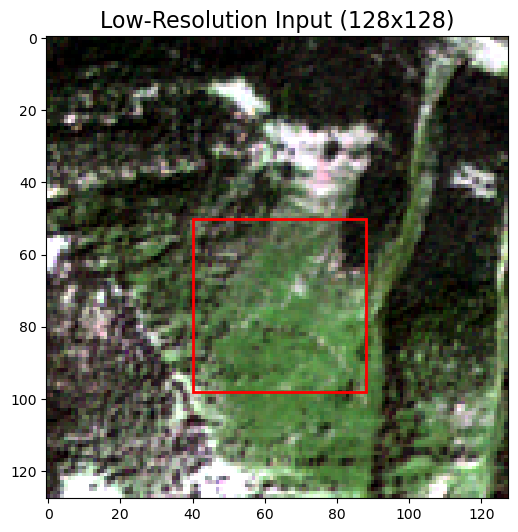

In [ ]:
comparison_data_1 = generate_comparison_data(
    dataset=test_dataset, index=300,
    model_16_block=model_16_block, model_8_block=model_8_block,
    device_16_block=device_16_block, device_8_block=device_8_block
)
plot_final_comparison(comparison_data_1, zoom_rect=(40, 50, 48, 48))

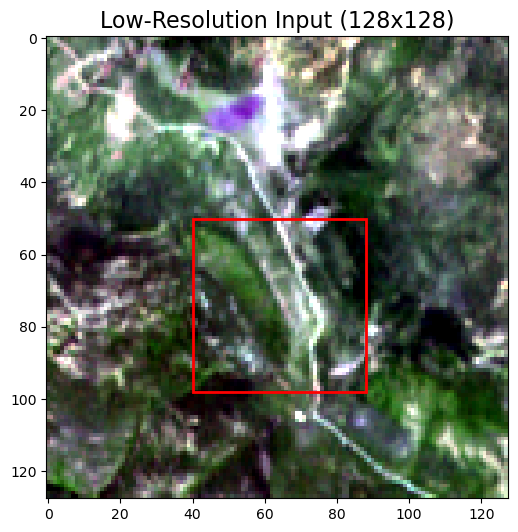

In [ ]:
comparison_data_2 = generate_comparison_data(
    dataset=test_dataset, index=260,
    model_16_block=model_16_block, model_8_block=model_8_block,
    device_16_block=device_16_block, device_8_block=device_8_block
)
plot_final_comparison(comparison_data_2, zoom_rect=(40, 50, 48, 48))

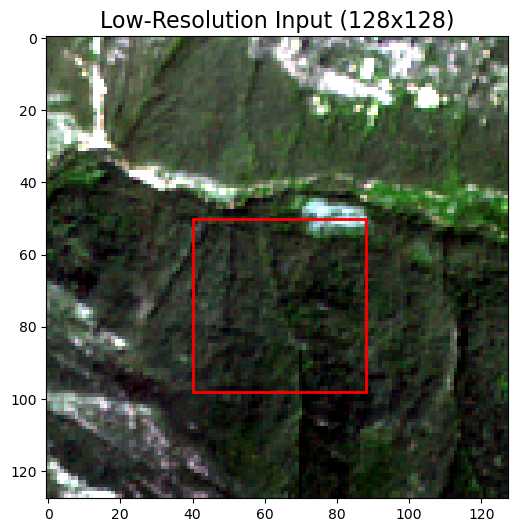

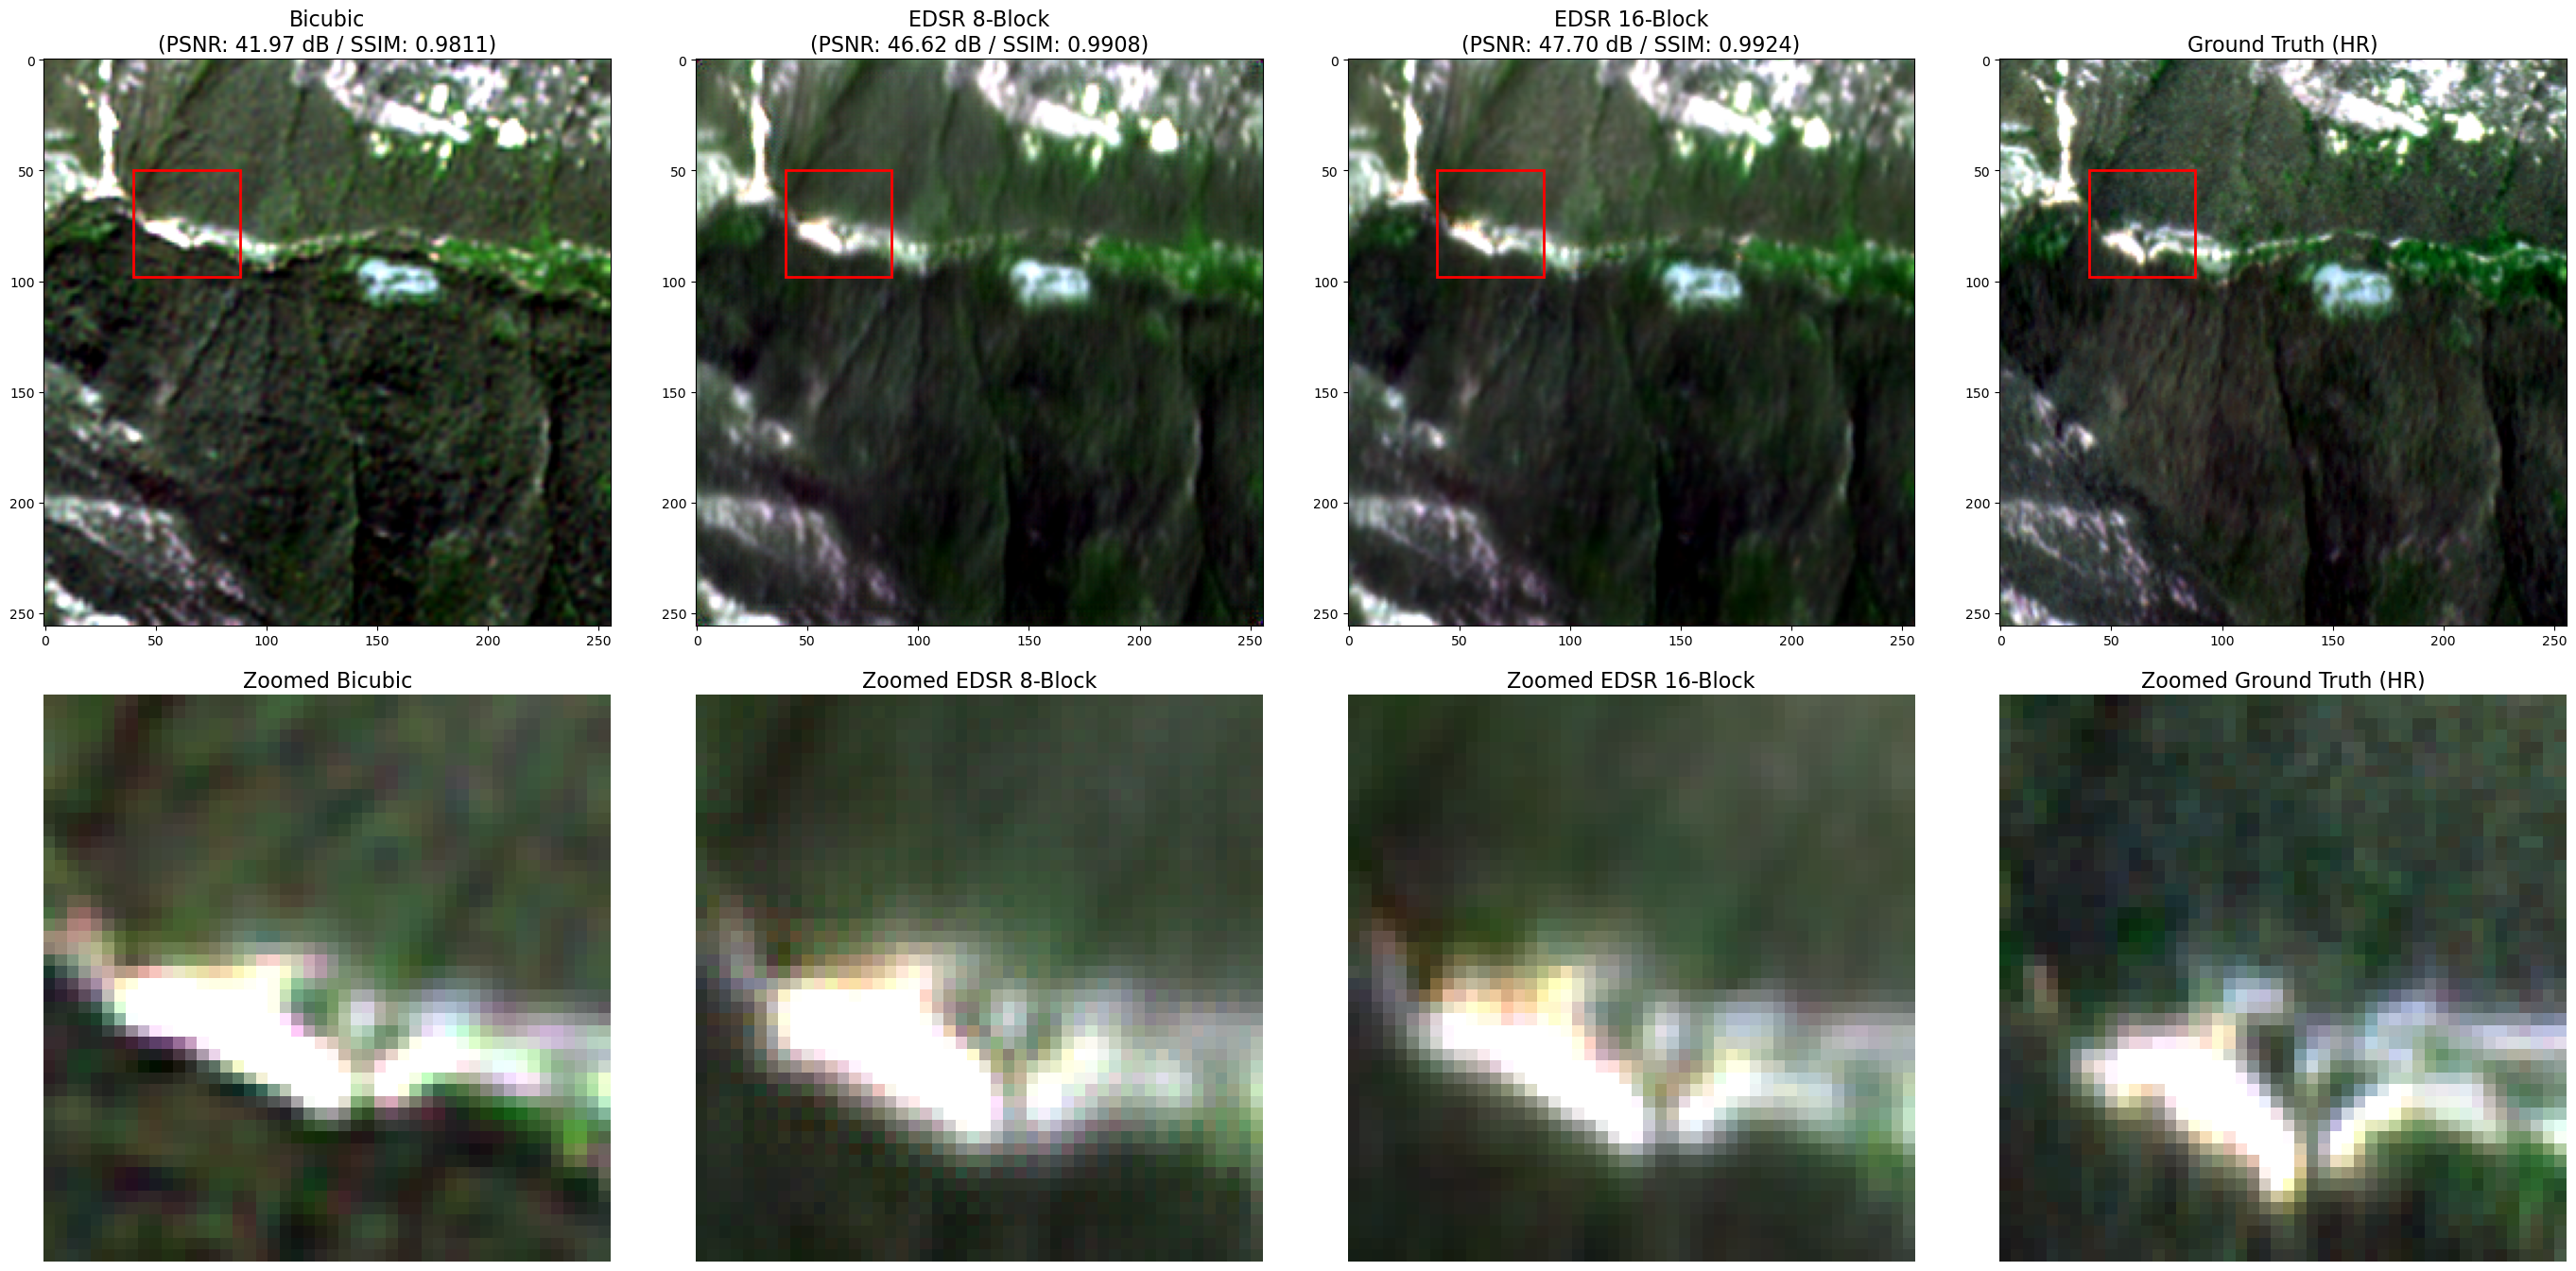

In [ ]:
comparison_data_3 = generate_comparison_data(
    dataset=test_dataset, index=80,
    model_16_block=model_16_block, model_8_block=model_8_block,
    device_16_block=device_16_block, device_8_block=device_8_block
)
plot_final_comparison(comparison_data_3, zoom_rect=(40, 50, 48, 48))